In [100]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, AffinityPropagation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from wellcomeml.ml.bert_vectorizer import BertVectorizer
import umap
from sklearn.manifold import TSNE
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

In [3]:
os.chdir('../')
data = pd.read_csv('data/processed/tool_grants.csv')

2020-09-10 17:07:30 transformers.file_utils INFO: PyTorch version 1.5.1+cpu available.
2020-09-10 17:07:30 transformers.modeling_xlnet INFO: Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex .
2020-09-10 17:07:30 wellcomeml.logger WARNING: Using WellcomeML without extras (transformers & torch).


In [6]:
data

,Financial Year,Internal ID,Applicant Surname,Lead Applicant,Other Applicant(s),Sponsor(s),Grant Programme:Title,Recipient Org:Name,Region,Recipient Org:Country,...,Planned Dates:Start Date,Planned Dates:End Date,Currency,Amount Awarded,Award Date,Approval Committee,Identifier,Recipient Org:Identifier,Funding Org:Name,Funding Org:Identifier
0,2018/19,219647/Z/19/Z,Lucas,Miss Alison Lucas,NaN,NaN,Discretionary Award - OPOH,Clean Air Fund,Greater London,United Kingdom,...,2019-09-24,2019-10-24,GBP,"30,000",2019-09-30,Internal Decision Panel,360G-Wellcome-219647_Z_19_Z,360G-Wellcome-ORG:Clean-Air-Fund,The Wellcome Trust,GB-CHC-210183
1,2018/19,219634/A/19/Z,King,Mr Edward King,NaN,NaN,DFID-Wellcome Epidemic Preparedness Grant,UNICEF UK,Greater London,United Kingdom,...,2019-10-01,2020-09-30,GBP,"56,063",2019-09-30,Internal Decision Panel,360G-Wellcome-219634_A_19_Z,360G-Wellcome-ORG:UNICEF-UK,The Wellcome Trust,GB-CHC-210183
2,2018/19,219603/Z/19/Z,Collins,Prof Sir Rory Collins,NaN,NaN,Strategic Support: Science,UK Biobank Ltd,North West,United Kingdom,...,2019-10-01,2024-12-31,GBP,"20,000,000",2019-09-30,Internal Decision Panel,360G-Wellcome-219603_Z_19_Z,360G-Wellcome-ORG:UK-Biobank-Ltd,The Wellcome Trust,GB-CHC-210183
3,2018/19,219574/Z/19/Z,Jackson,Prof Malcolm Jackson,NaN,NaN,Innovations Translational Partnership Award,University of Liverpool,North West,United Kingdom,...,2020-04-01,2022-03-31,GBP,"600,000",2019-09-30,Internal Decision Panel,360G-Wellcome-219574_Z_19_Z,360G-Wellcome-ORG:University-of-Liverpool,The Wellcome Trust,GB-CHC-210183
4,2018/19,219429/Z/19/Z,Thomas,Prof Pam Thomas,NaN,NaN,Innovations Translational Partnership Award,University of Warwick,West Midlands,United Kingdom,...,2020-04-01,2022-03-31,GBP,"600,000",2019-09-30,Internal Decision Panel,360G-Wellcome-219429_Z_19_Z,360G-Wellcome-ORG:University-of-Warwick,The Wellcome Trust,GB-CHC-210183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2174,2005/06,064890/Z/01/B,Cardon,Prof Lon Cardon,NaN,NaN,Principal Research Fellowship Programme,University of Oxford,South East,United Kingdom,...,2006-10-01,2011-09-30,GBP,"1,356,170",2006-02-21,"Molecules, Genes and Cells Funding Committee",360G-Wellcome-064890_Z_01_B,360G-Wellcome-ORG:University-of-Oxford,The Wellcome Trust,GB-CHC-210183
2175,2005/06,064405/Z/01/A,Murshudov,Dr Garib Murshudov,NaN,Prof Keith Wilson,Senior Research Fellowship Basic,University of York,Yorkshire and the Humber,United Kingdom,...,2006-11-01,2008-05-31,GBP,"188,746",2006-06-29,Basic Science Interview Committee,360G-Wellcome-064405_Z_01_A,360G-Wellcome-ORG:University-of-York,The Wellcome Trust,GB-CHC-210183
2176,2005/06,063729/Z/01/A,Webb,Prof David Webb,NaN,NaN,Project funding: Inactive scheme,University of Edinburgh,Scotland,United Kingdom,...,2006-07-01,2006-12-31,GBP,"58,750",2006-07-19,Technology Transfer Challenge Committee,360G-Wellcome-063729_Z_01_A,360G-Wellcome-ORG:University-of-Edinburgh,The Wellcome Trust,GB-CHC-210183
2177,2005/06,062452/Z/00/A,Garety,Prof Philippa Garety,"Prof Graham Dunn, Prof Paul Bebbington, Prof D...",NaN,Programme Grant,King's College London,Greater London,United Kingdom,...,2006-02-01,2006-09-30,GBP,"55,000",2006-01-23,Neurosciences And Mental Health,360G-Wellcome-062452_Z_00_A,360G-Wellcome-ORG:Kings-College-London,The Wellcome Trust,GB-CHC-210183


In [75]:
colour_list = [k for k in mcolors.CSS4_COLORS.keys()]
colour_list.remove('black')

In [18]:
def desc_vectorizer(description,ngram_range,vectorizer_type,bert_type):
    if vectorizer_type == 'count':
        vectorizer = CountVectorizer(
            analyzer='word',
            token_pattern=r'(?u)\b\w+\b',
            ngram_range=ngram_range
            )
    elif vectorizer_type == 'tfidf':
        vectorizer = TfidfVectorizer(
            analyzer='word',
            token_pattern=r'(?u)\b\w+\b',
            ngram_range=ngram_range
            )
    elif vectorizer_type == 'bert':
        vectorizer = BertVectorizer(pretrained=bert_type)
    else:
        print('Vectorizer type not recognised')
    transformed_data = vectorizer.fit_transform(description)

    
    return transformed_data
    

In [ ]:
def plot_raw(data):
    plt.scatter(data[:,0],data[:,1] )
    plt.show()

In [ ]:
def plot_cluster(data,cluster_labels, plot_name):
    unique_labels = np.unique(cluster_labels)
    plt.figure(figsize=(10, 10))
    for i in unique_labels: 
        indx = [idx for idx,n in enumerate(cluster_labels) if n == i]
        if i == -1:
            colour = 'black'
        else:
            colour = colour_list[i]
        plt.scatter(data[indx,0],data[indx,1], c = colour, alpha = 0.6)
    plt.title(plot_name)
    plt.xticks(())
    plt.yticks(())
    plt.show()
    

## Scibert X PCA X DBSCAN

In [ ]:
scibert_desc = desc_vectorizer(data['Description'].to_list(),ngram_range = (1,2),vectorizer_type = 'bert',bert_type = 'scibert')


In [ ]:
print(scibert_desc)
print(len(scibert_desc))
print(scibert_desc.shape)

In [ ]:
pca = PCA(n_components = 0.9)
pca_sci_desc = pca.fit_transform(scibert_desc)
print(pca_sci_desc.shape)

In [ ]:
plot_raw(pca_sci_desc)

In [ ]:
plt.plot(pca.explained_variance_ratio_)
plt.show()

In [ ]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(pca_sci_desc)
distances, indices = nbrs.kneighbors(pca_sci_desc)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [ ]:
db = DBSCAN(eps = 13).fit(pca_sci_desc)

In [ ]:
clusters = db.labels_
np.unique(clusters)

In [ ]:
plot_cluster(pca_sci_desc,clusters,'Scibert PCA DBSCAN')

In [78]:
def plot_cluster(data,cluster_labels, plot_name):
    unique_labels = np.unique(cluster_labels)
    plt.figure(figsize=(10, 10))
    for i in unique_labels: 
        indx = [idx for idx,n in enumerate(cluster_labels) if n == i]
        if i == -1:
            colour = 'black'
        else:
            colour = colour_list[i]
        plt.scatter(data[indx,0],data[indx,1], c = colour, alpha = 0.6)
    plt.title(plot_name)
    plt.xticks(())
    plt.yticks(())
    plt.show()
    

## Scibert X PCA X DBSCAN

In [29]:
scibert_desc = desc_vectorizer(data['Description'].to_list(),ngram_range = (1,2),vectorizer_type = 'bert',bert_type = 'scibert')


2020-09-10 17:45:34 wellcomeml.logger INFO: Using C:\Users\nonie/.cache/wellcomeml/models\scibert_scivocab_uncased embedding
2020-09-10 17:45:34 transformers.configuration_utils INFO: loading configuration file C:\Users\nonie/.cache/wellcomeml/models\scibert_scivocab_uncased\config.json
2020-09-10 17:45:34 transformers.configuration_utils INFO: Model config {
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "output_attentions": false,
  "output_hidden_states": true,
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 2,
  "use_bfloat16": false,
  "vocab_size": 31090
}

2020-09-10 17:45:34 transformers.modeling_utils INFO: loading weights file C:\Users\nonie/.cache/wellcomeml/models\scibe

In [33]:
print(scibert_desc)
print(len(scibert_desc))
print(scibert_desc.shape)

[[-0.93512523  0.43466264 -0.08107142 ...  0.24600132  0.19372275
  -1.3792396 ]
 [ 0.90778494  0.4561499   0.79504496 ... -0.14125904  0.48494524
  -1.9665728 ]
 [-0.7495432   0.9859593   0.15579726 ...  0.8236975   0.8994099
  -1.6106691 ]
 ...
 [ 0.34418055 -0.27567014  0.38957322 ...  0.25209734  1.3446734
  -0.836565  ]
 [ 0.11241753 -0.19050804 -0.41814092 ... -0.9827088   0.8560538
  -1.9340403 ]
 [ 0.31780803 -0.13214643  0.24290435 ...  0.2801269   1.1360469
  -0.22758521]]
2179
(2179, 768)


In [42]:
pca = PCA(n_components = 0.9)
pca_sci_desc = pca.fit_transform(scibert_desc)
print(pca_sci_desc.shape)

(2179, 42)


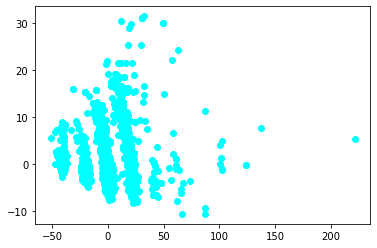

In [73]:
plot_raw(pca_sci_desc)

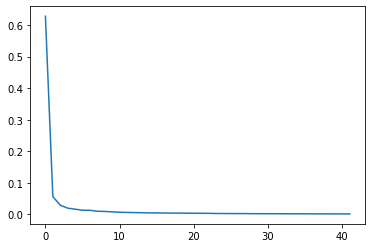

In [44]:
plt.plot(pca.explained_variance_ratio_)
plt.show()

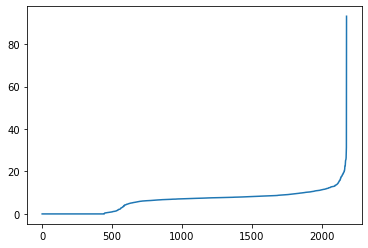

In [101]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(pca_sci_desc)
distances, indices = nbrs.kneighbors(pca_sci_desc)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [118]:
db = DBSCAN(eps = 13).fit(pca_sci_desc)

In [119]:
clusters = db.labels_
np.unique(clusters)

array([-1,  0,  1,  2,  3,  4,  5], dtype=int64)

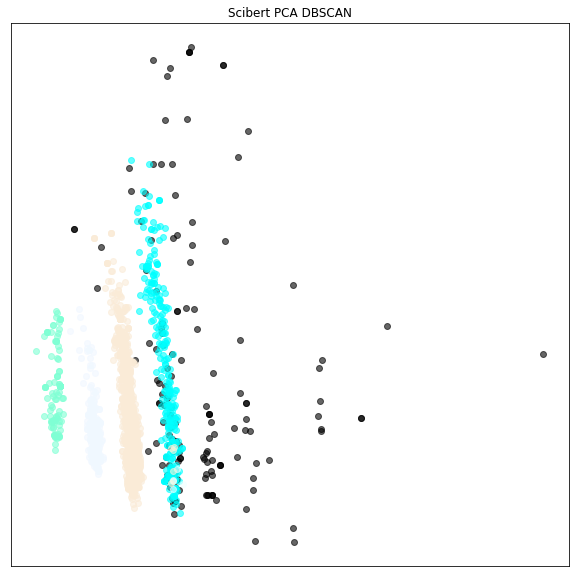

In [120]:
plot_cluster(pca_sci_desc,clusters,'Scibert PCA DBSCAN')